# Aligning data to the Allen reference atlas using Landmarks

This tutorial shows how to access data from <[DANDI:00XXXX](https://dandiarchive.org/dandiset/00XXXX/draft)> for the IBL widefield dataset
and align data to the Allen reference atlas using Landmarks.

## Study Overview

[TODO add description]

## Contents

1. [Setup and Data Access](#setup)
2. [Temporal components](#temporal-components)
3. [Spatial components](#spatial-components)
4. [Summary images](#summary-images)
4. [Landmarks](#landmarks)
5. [Anatomical localization](#anatomical-coordinates)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [1]:
# Core data manipulation and analysis
# Visualization
import matplotlib.pyplot as plt

# NWB access
from pynwb import read_nwb
from skimage.transform import SimilarityTransform

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Read NWB file from local path

You can read the NWB file from a local path using `pynwb.read_nwb()`.

In [2]:
subject_id = "CSK-im-009"  # Example subject
session_id = "2864dca1-38d8-464c-9777-f6fdfd5e63b5"  # EID for the session

# Read NWB file from local path
nwbfile_path = f"/Volumes/T9/data/IBL/nwbfiles/sub-{subject_id}_ses-{session_id}_desc-processed_ophys+behavior.nwb"
nwbfile = read_nwb(nwbfile_path)

---

# 2. Temporal components <a id="temporal-compontents"></a>

The SVD temporal components are stored in the `ophys` processing module within the "SVDTemporalComponents" container.

Data shape
- Arrays are shaped `(time, num_components)` — the first dimension is time (frame), the second is the number of components.


Denoised/decomposed series names:
- Calcium (470 nm): `DenoisedSVDTemporalComponentsCalcium`
- Isosbestic (405 nm): `DenoisedSVDTemporalComponentsIsosbestic`
Haemodynamically corrected series name:
- Calcium (470 nm): `HaemoCorrectedSVDTemporalComponentsCalcium`

Access example
```python
SVD_temporal_components = nwbfile.processing["ophys"]["SVDTemporalComponents"]["DenoisedSVDTemporalComponentsCalcium"]
```

In [3]:
print(f"=== SVD Temporal components: ===")
print("-" * 100)
svd_module = nwbfile.processing["ophys"]["SVDTemporalComponents"]
for _, temporal_components in svd_module.roi_response_series.items():
    print(f"Trace: {temporal_components.name}")
    print("-" * 100)
    print(f"   Description: {temporal_components.description}")
    print(f"   Number of ROIs: {temporal_components.data.shape[1]}")
    print(f"   Duration: {temporal_components.timestamps[-1] - temporal_components.timestamps[0]:.2f} seconds")
    print("-" * 100)

=== SVD Temporal components: ===
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Blue light (470 nm) excitation.
   Number of ROIs: 200
   Duration: 4920.59 seconds
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Violet light (405 nm) excitation.
   Number of ROIs: 200
   Duration: 4920.59 seconds
----------------------------------------------------------------------------------------------------
Trace: Ha

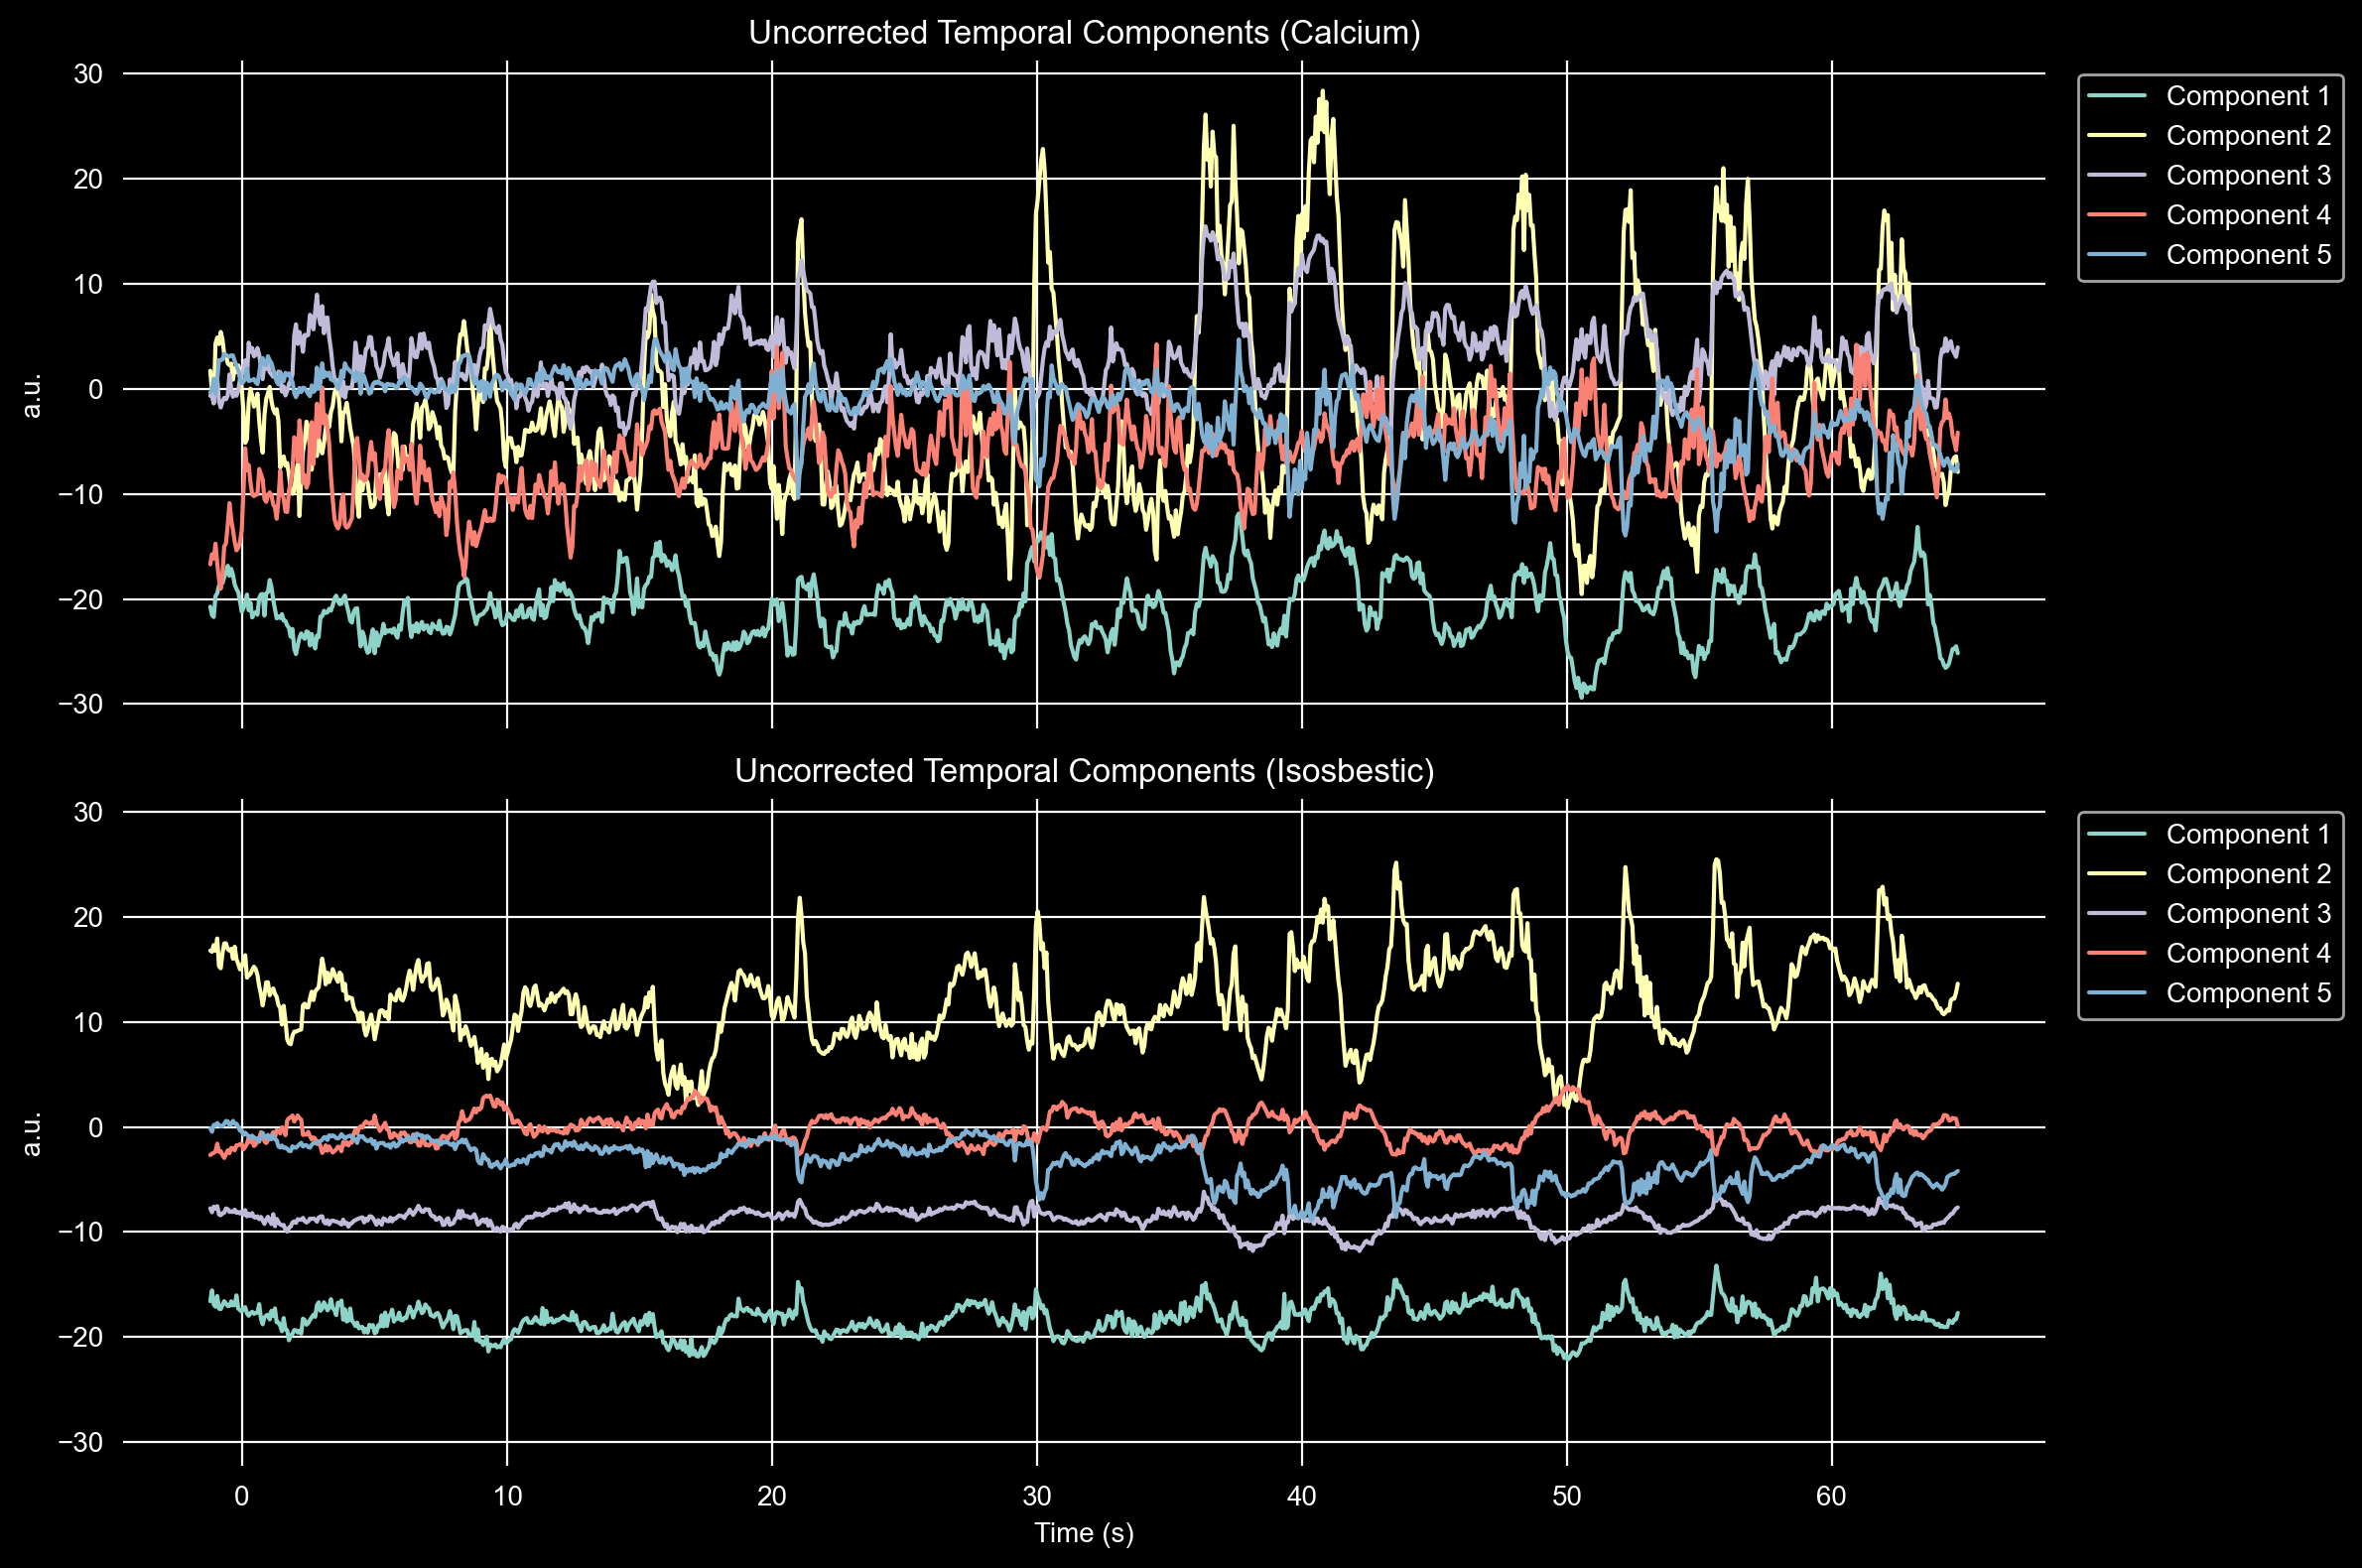

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True, sharey=True)

num_rois = 5
roi_response = svd_module.roi_response_series["DenoisedSVDTemporalComponentsCalcium"]
time = roi_response.timestamps[:1000]  # First 1000 time points
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[0].plot(time, roi_response.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[0].set_title('Uncorrected Temporal Components (Calcium)')
ax[0].set_ylabel('a.u.')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[0].set_frame_on(False)

roi_response_iso = svd_module.roi_response_series["DenoisedSVDTemporalComponentsIsosbestic"]
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[1].plot(time, roi_response_iso.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[1].set_title('Uncorrected Temporal Components (Isosbestic)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('a.u.')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].set_frame_on(False)
plt.tight_layout()

plt.show()

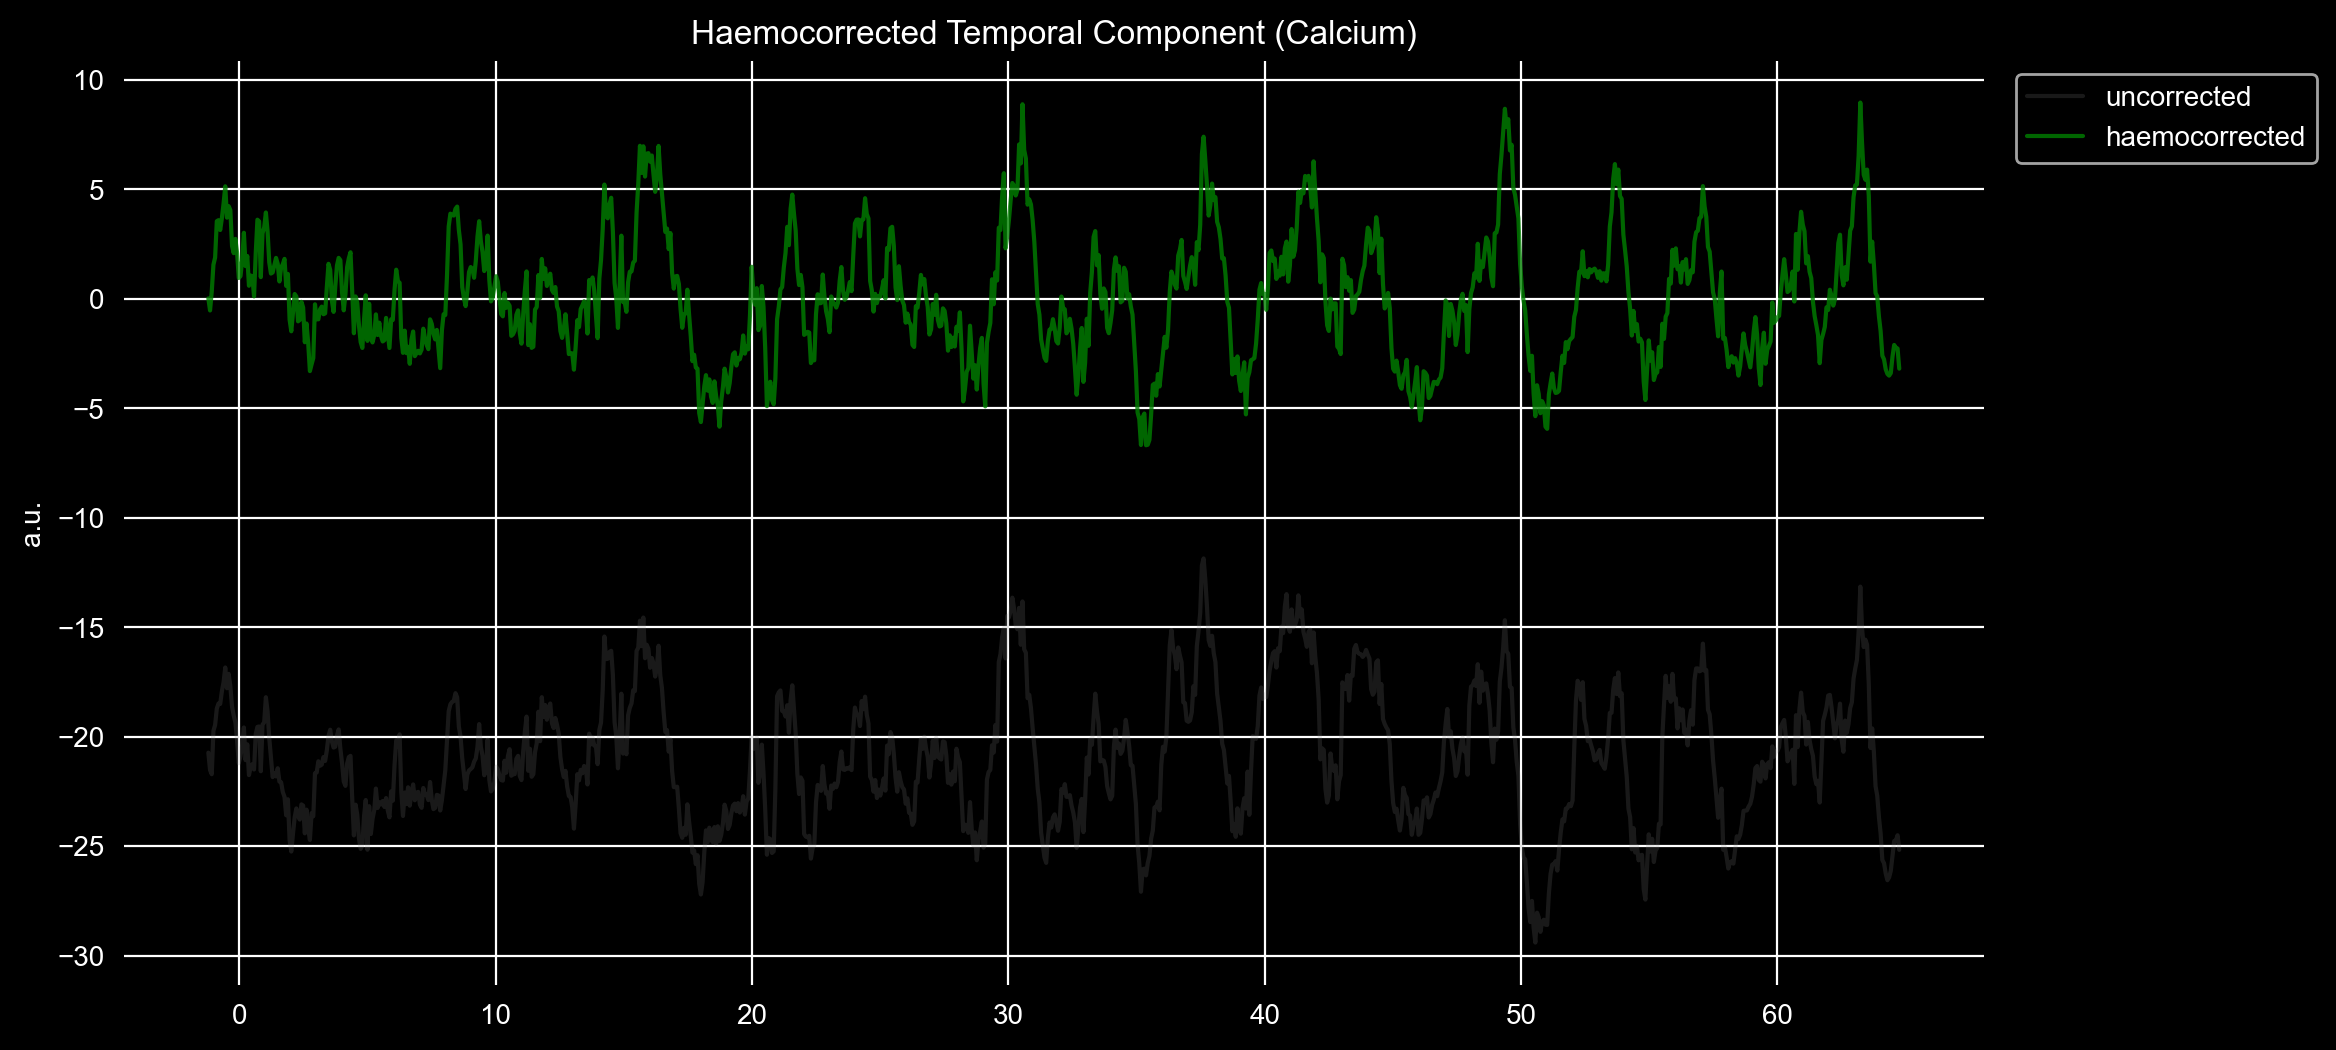

In [5]:
fig, ax = plt.subplots(dpi=200)

roi_response_dff = svd_module["HaemoCorrectedSVDTemporalComponentsCalcium"]
roi_response_raw = svd_module["DenoisedSVDTemporalComponentsCalcium"]

time = roi_response_raw.timestamps[:1000]  # First 1000 time points
ax.plot(time, roi_response_raw.data[:1000, 0], label="uncorrected", color="grey", alpha=0.2)
ax.plot(time, roi_response_dff.data[:1000, 0], label="haemocorrected", color="green", alpha=0.8)
ax.set_title('Haemocorrected Temporal Component (Calcium)')
ax.set_ylabel('a.u.')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_frame_on(False)

plt.show()

---

# 3. Spatial components <a id="spatial-compontents"></a>

The spatial components are stored in the `ophys` processing module within the "SVDSpatialComponents" container.

Data shape
- Arrays are shaped `(num_components, height, width)` — the first dimension is the number of components, the second and third are the image size (e.g. `(200, 540, 640)`)

Spatial components names:
- Calcium (470 nm): `SVDTemporalComponentsCalcium`
- Isosbestic (405 nm): `SVDTemporalComponentsIsosbestic`

Access example
```python
spatial_components = nwbfile.processing["ophys"]["SVDSpatialComponents"]["SVDTemporalComponentsCalcium"]
```

In [6]:
print(f"=== Spatial Components: ===")
print("-" * 100)
spatial_components_module = nwbfile.processing["ophys"]["SVDSpatialComponents"]
for _, plane_segmentation in spatial_components_module.plane_segmentations.items():
    print(f"Plane Segmentation: {plane_segmentation.name}")
    print("-" * 100)
    print(f"   Description: {plane_segmentation.description}")
    print(f"   Linked Imaging Plane: {plane_segmentation.imaging_plane.name}")
    print(f"   ROIs properties: {plane_segmentation.colnames}")
    print("-" * 100)

=== Spatial Components: ===
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneCalcium
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneIsosbestic
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------


In [7]:
plane_segmentation = spatial_components_module["SVDTemporalComponentsCalcium"]
# view plane segmentation table
plane_segmentation.to_dataframe()

,roi_name,image_mask
id,,
0,0,"[[0.041995365, 0.03945256, 0.03720876, 0.03650..."
1,1,"[[-0.02643075, -0.015914066, -0.014987613, -0...."
2,2,"[[-0.0145443035, 0.009987158, 0.0079432465, 0...."
3,3,"[[-0.03683752, -0.0025825198, -0.0023083454, -..."
4,4,"[[-0.012025796, -0.0021518157, -0.0018589466, ..."
...,...,...
195,195,"[[0.018911257, 0.007712466, 0.04889216, 0.0266..."
196,196,"[[0.021622432, 0.012585476, 0.06765012, 0.0340..."
197,197,"[[0.01008541, 0.0077144112, 0.010999754, 0.012..."


In [8]:
plane_segmentation["image_mask"].shape

(200, 540, 640)

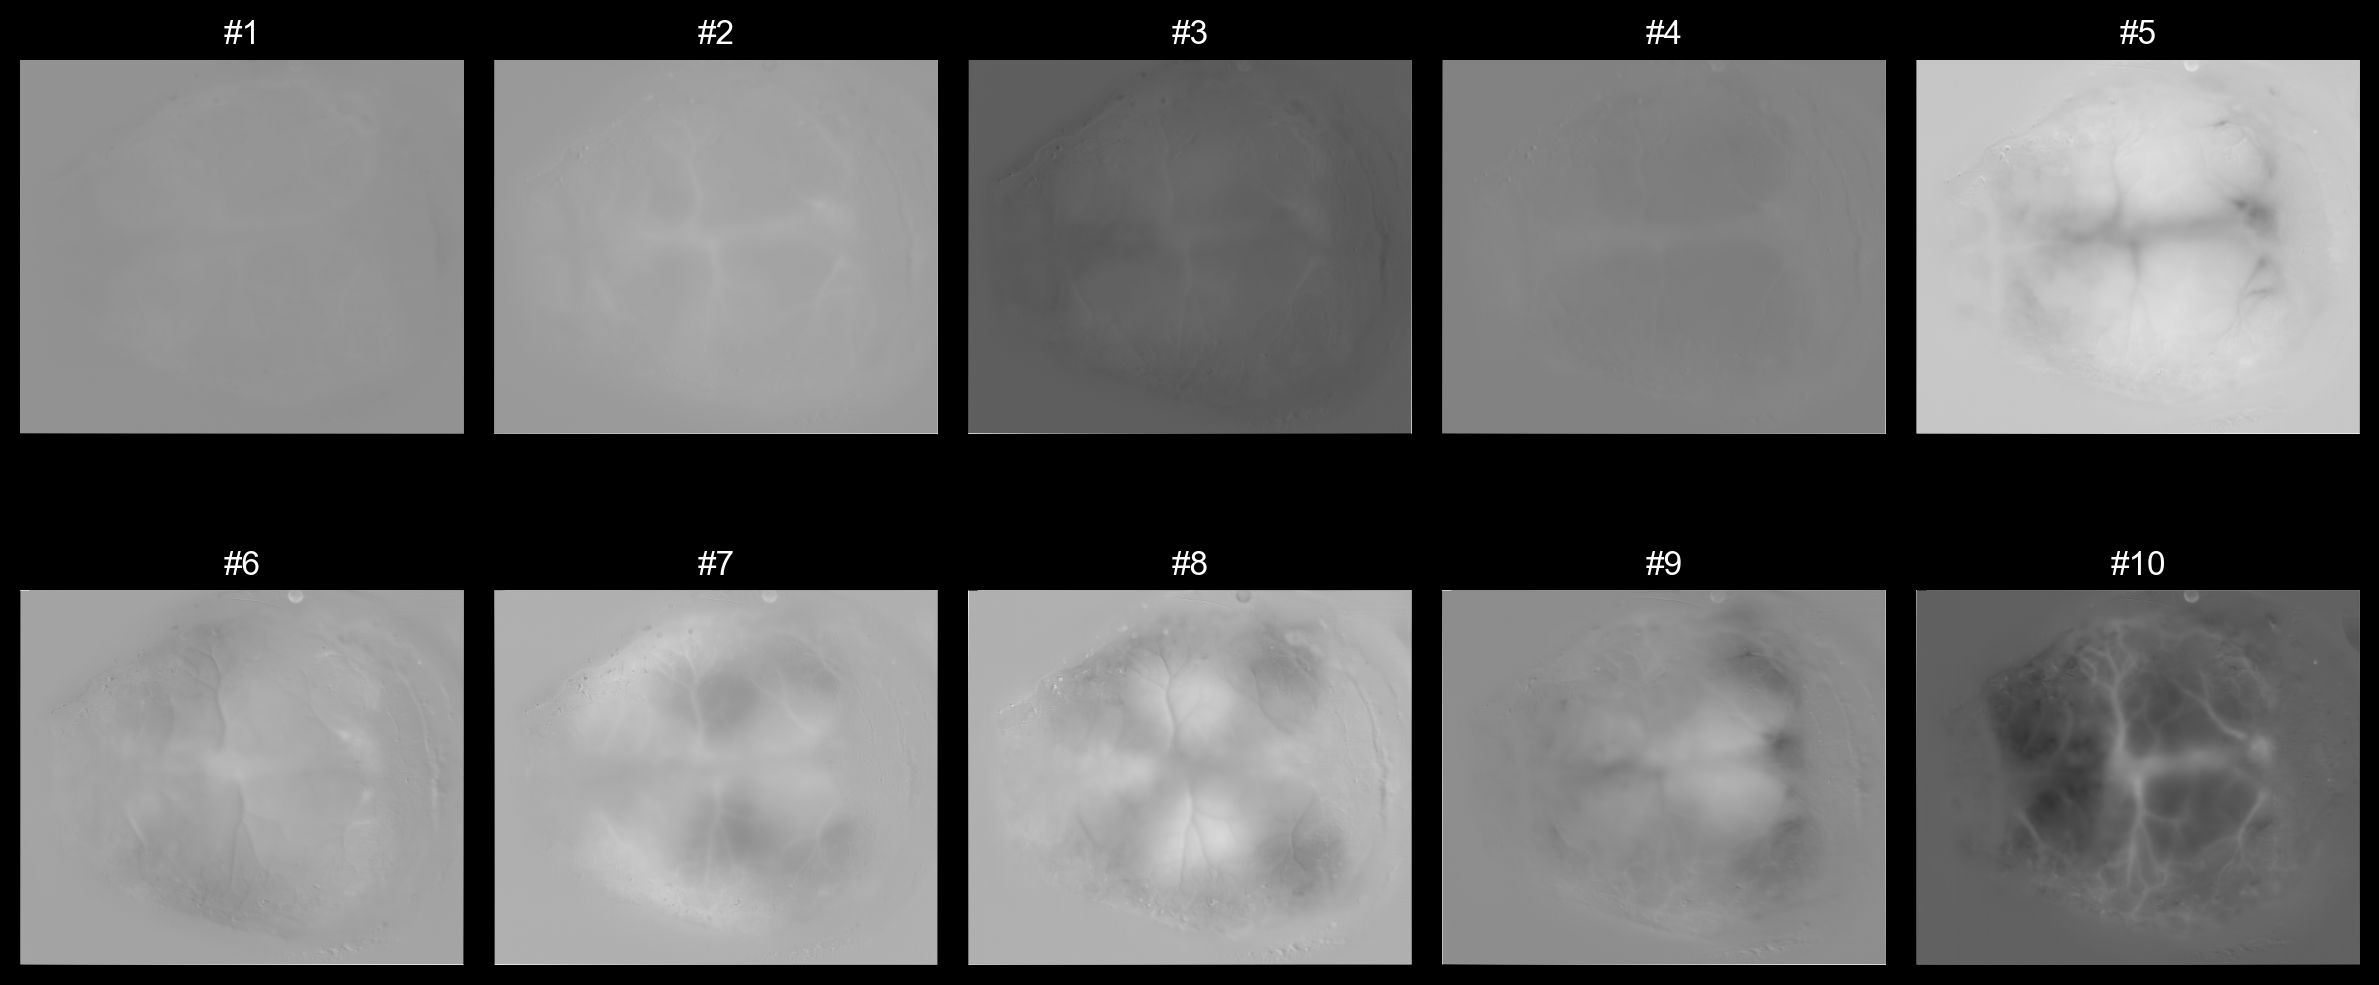

In [9]:
# view example spatial components
roi_ids = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)
for ax, roi_id in zip(axes.flatten(), roi_ids):
    ax.imshow(plane_segmentation["image_mask"][roi_id], cmap="gray")
    ax.set_title(f'#{roi_id + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

---

# 4. Summary images <a id="summary-images"></a>

The summary images are stored in GrayscaleImage objects in an Images container within the "ophys" processing module.

In [3]:
print(f"=== SUMMARY IMAGES: ===")
print("-" * 100)
summary_images = nwbfile.processing["ophys"]["SummaryImages"]
for _, summary_image in summary_images.images.items():
    print(f"Image: {summary_image.name}")
    print("-" * 100)
    print(f"   Description: {summary_image.description}")
    print(f"   Dimensions: {summary_image.data.shape}")
    print("-" * 100)

=== SUMMARY IMAGES: ===
----------------------------------------------------------------------------------------------------
Image: MeanImage
----------------------------------------------------------------------------------------------------
   Description: The mean image under Blue (470 nm) excitation across the imaging session. The dimensions are (height, width).
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------
Image: MeanImageIsosbestic
----------------------------------------------------------------------------------------------------
   Description: The mean image under Violet (405 nm) excitation across the imaging session. The dimensions are (height, width).
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------


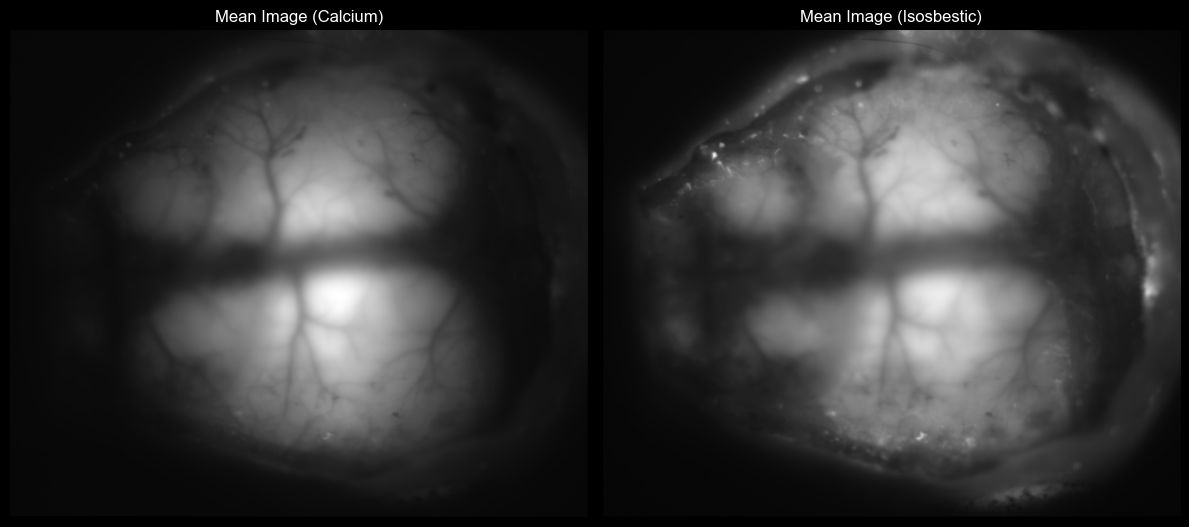

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

mean_image = summary_images.images["MeanImage"]
axes[0].imshow(mean_image, cmap="gray")
axes[0].set_title('Mean Image (Calcium)')
axes[0].axis('off')

mean_image_isosbestic = summary_images.images["MeanImageIsosbestic"]
axes[1].imshow(mean_image_isosbestic, cmap="gray")
axes[1].set_title('Mean Image (Isosbestic)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# 5. Aligning data to the Allen reference atlas using Landmarks <a id="landmarks"></a>

The imaging stack can be reconstructed from the decomposed spatial and temporal components of the SVD. The imaging stack contains the imaging data for each frame in the session and has dimensions (time, height, width).

In [5]:
spatial_transformation_metadata = nwbfile.lab_meta_data["SpatialTransformationMetadata"]
spatial_transformation_metadata

SpatialTransformationMetadata abc.SpatialTransformationMetadata at 0x5029845120
Fields:
  landmarks: {
    Landmarks <class 'abc.Landmarks'>
  }
  spatial_transformations: {
    AffineTransformation <class 'abc.AffineTransformation'>
  }

In [6]:
affine_transformation = spatial_transformation_metadata.spatial_transformations["AffineTransformation"]

print("=== Transform ===")
print("-" * 100)
print(f"Source Image: {summary_images.images["MeanImage"].name}")
print("-" * 100)
print(f"   Affine matrix (3x3): ")
for i in range(3):
    print(f"   [{affine_transformation.affine_matrix[i,0]: .4f}  {affine_transformation.affine_matrix[i,1]: .4f} {affine_transformation.affine_matrix[i,2]: .4f}]")


=== Transform ===
----------------------------------------------------------------------------------------------------
Source Image: MeanImage
----------------------------------------------------------------------------------------------------
   Affine matrix (3x3): 
   [-0.1192   0.9668  68.2827]
   [-0.9668  -0.1192  597.9486]
   [ 0.0000   0.0000  1.0000]


In [7]:
landmarks = spatial_transformation_metadata.landmarks["Landmarks"]
landmarks[:]

,source_x,source_y,target_x,target_y,reference_x,reference_y,landmark_labels,color,bregma_offset_x,bregma_offset_y,resolution
id,,,,,,,,,,,
0,122.828237,374.740614,219.484536,92.164948,375.0,195.0,OB_left,#fc9d03,320,270,19.4
1,130.722445,277.078329,320.000000,92.164948,570.0,195.0,OB_center,#0367fc,320,270,19.4
2,103.608284,182.378204,420.515464,92.164948,765.0,195.0,OB_right,#fc9d03,320,270,19.4
3,451.217499,235.361147,320.000000,434.948454,570.0,860.0,RSP_base,#fc4103,320,270,19.4


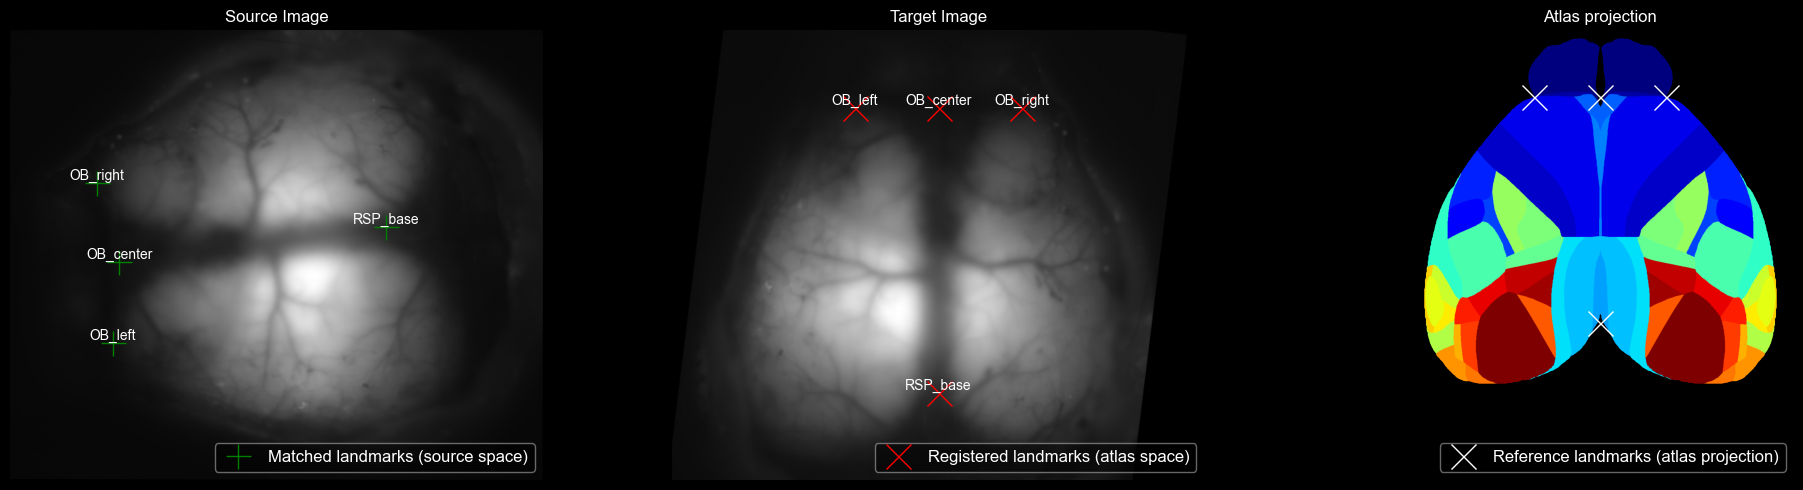

In [139]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)

landmarks_df = landmarks[:]
mean_image = summary_images.images["MeanImage"]
mean_image_transformed = nwbfile.processing["ophys"]["TransformedImages"]["TransformedMeanImage"].data[:]

axes[0].imshow(mean_image.data[:], cmap="gray")
axes[0].set_title('Source Image')
axes[0].axis('off')

axes[0].plot(
    landmarks_df["source_x"].values,
    landmarks_df["source_y"].values,
    "g+",
    ms=18,
    label="Matched landmarks (source space)",
)

# label each source point
for _, row in landmarks_df.iterrows():
    axes[0].text(
        row["source_x"],
        row["source_y"],
        row["landmark_labels"],
        color="w",
        va="bottom",
        ha="center",
    )

axes[1].imshow(mean_image_transformed, cmap="gray")
axes[1].set_title('Target Image')
axes[1].axis('off')

axes[1].plot(
    landmarks_df["target_x"].values,
    landmarks_df["target_y"].values,
    "rx",
    ms=18,
    label="Registered landmarks (atlas space)",
)

for _, row in landmarks_df.iterrows():
    axes[1].text(
        row["target_x"],
        row["target_y"],
        row["landmark_labels"],
        color="w",
        va="bottom",
        ha="center",
    )

proj = nwbfile.processing["ophys"]["TransformedImages"]["ReferenceProjectionImage"].data[:]
# mask out zeros
proj_m = np.ma.masked_equal(proj, 0)

# make masked values transparent
cmap = plt.get_cmap("jet").copy()
cmap.set_bad(alpha=0)

axes[2].imshow(proj_m, cmap=cmap)
axes[2].plot(
    landmarks_df["reference_x"].values,
    landmarks_df["reference_y"].values,
    "wx",
    ms=18,
    label="Reference landmarks (atlas projection)",
)
axes[2].set_title('Atlas projection')
axes[2].axis("off")


# --- Legends and annotation ---
axes[0].legend(loc="lower right", fontsize=12, frameon=True, facecolor="black", framealpha=0.5)
axes[1].legend(loc="lower right", fontsize=12, frameon=True, facecolor="black", framealpha=0.5)
axes[2].legend(loc="lower right", fontsize=12, frameon=True, facecolor="black", framealpha=0.5)

plt.tight_layout()
plt.show()

The imaging stack can be reconstructed from the decomposed spatial and temporal components of the SVD.
The imaging stack contains the imaging data for each frame in the session and has dimensions (nFrames, nx, ny) where nx is the width of the imaging window, and ny the height.

In [16]:
import numpy as np
import wfield

# Spatial components (U):
# plane_segmentation["image_mask"].data has shape: (num_rois, height, width)
U = plane_segmentation["image_mask"].data[:]          # (n_components, height, width)
print(f"Spatial components U shape (n_components, height, width): {U.shape}")

# Haemocorrected temporal components (SVT):
# roi_response_dff.data has shape: (time, num_rois)
SVT = roi_response_dff.data[:]                        # (time, n_components)
print(f"Temporal components SVT shape (time, n_components): {SVT.shape}")

# --- Prepare shapes for SVDStack ---

# wfield.SVDStack expects:
#   U_stack:  (height, width, n_components)
#   SVT_stack: (n_components, time)
U_stack = np.transpose(U, (1, 2, 0))                  # (height, width, n_components)
SVT_stack = SVT.T                                     # (n_components, time)

print(f"U_stack shape (height, width, n_components): {U_stack.shape}")
print(f"SVT_stack shape (n_components, time):         {SVT_stack.shape}")

# --- Build the reconstructed imaging stack ---
# Resulting stack has shape: (time, height, width)
stack = wfield.SVDStack(U_stack, SVT_stack)
print(f"Reconstructed stack shape (time, height, width): {stack.shape}")

Spatial components U shape (n_components, height, width): (200, 540, 640)
Temporal components SVT shape (time, n_components): (74531, 200)
U_stack shape (height, width, n_components): (540, 640, 200)
SVT_stack shape (n_components, time):         (200, 74531)
Reconstructed stack shape (time, height, width): [74531, 540, 640]


In [17]:
# Warp and register the image stack to the Allen dorsal
from skimage.transform import SimilarityTransform

M = SimilarityTransform(affine_transformation.affine_matrix)
stack.set_warped(True, M=M)

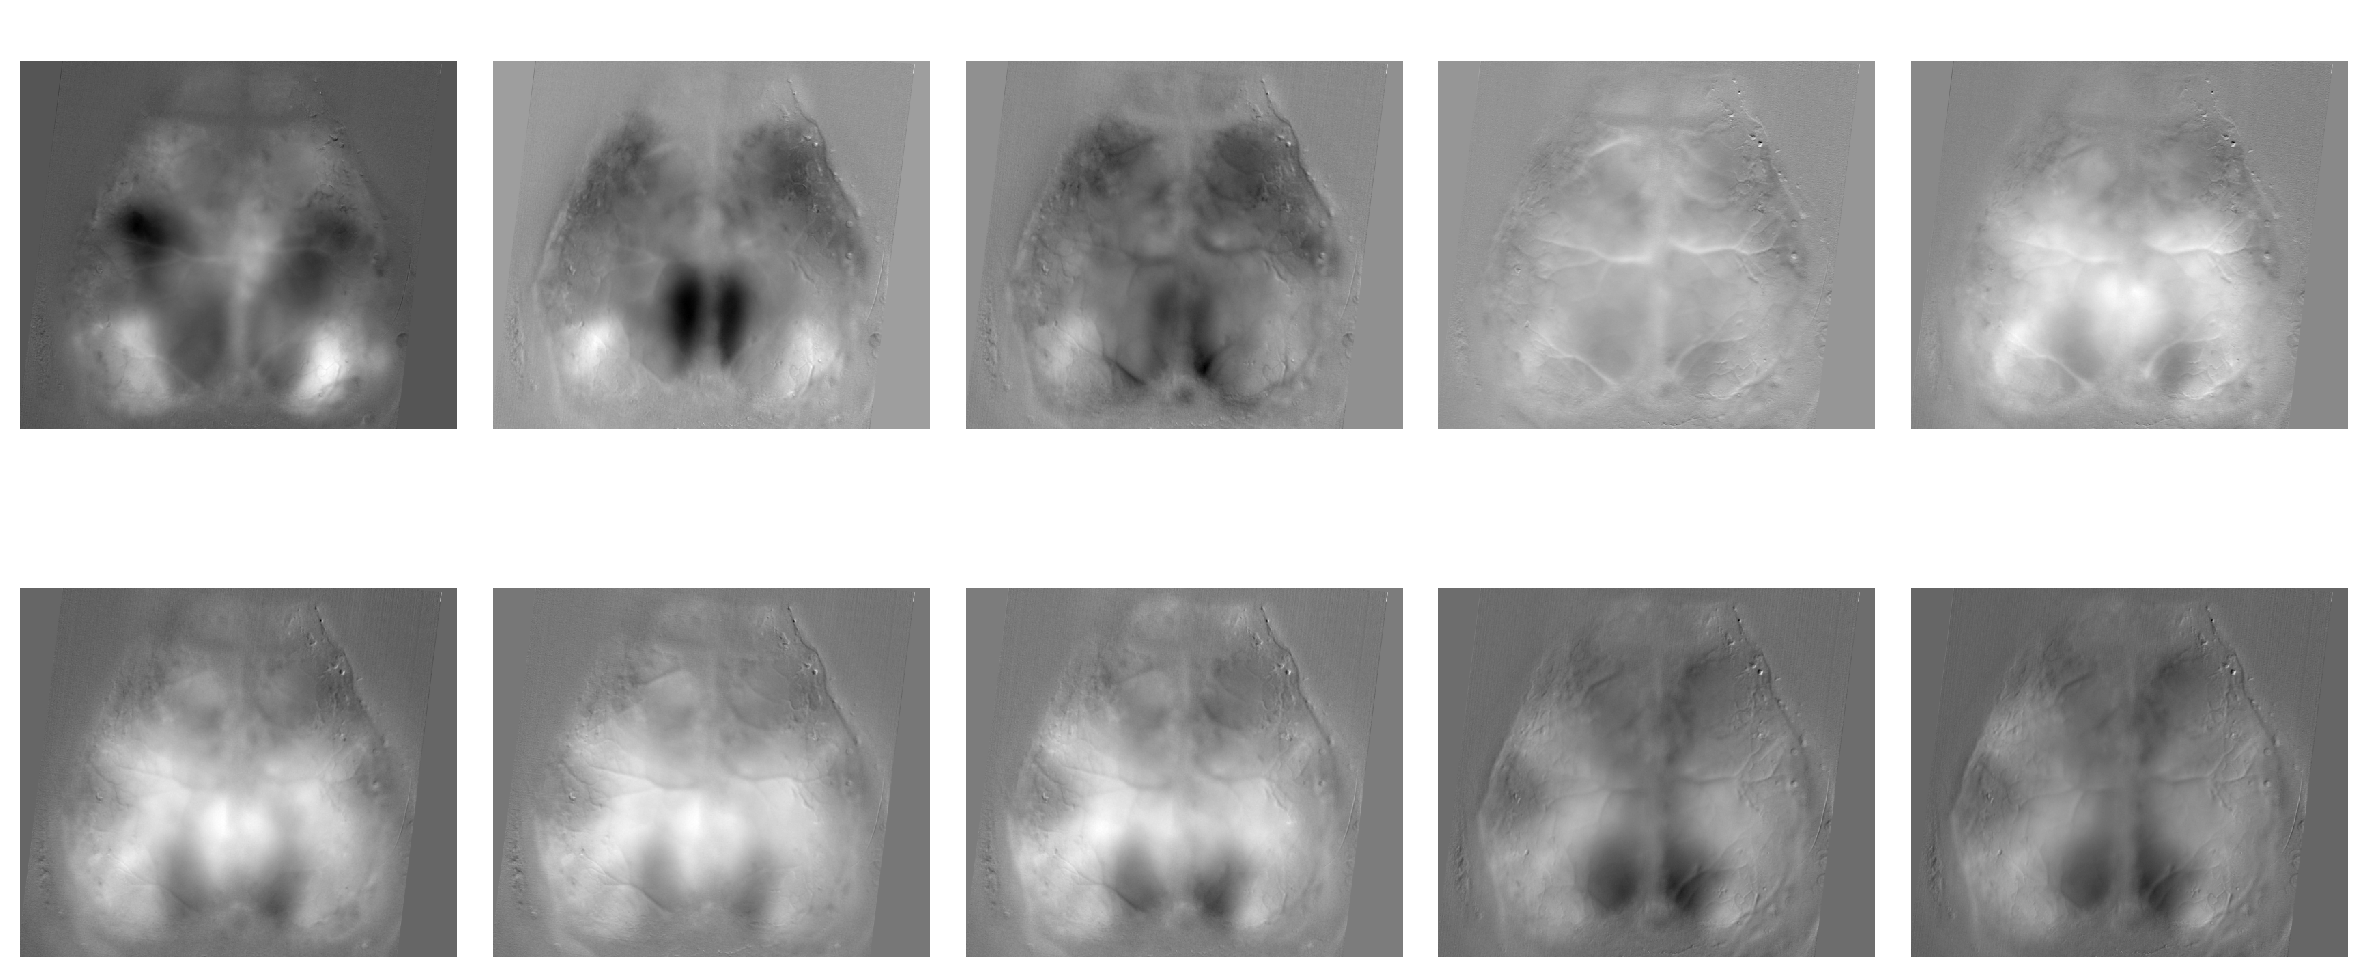

In [18]:
frames = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)

for ax, frame_ind in zip(axes.flatten(), frames):
    ax.imshow(stack[frame_ind], cmap="gray")
    ax.set_title(f"WarpedImageStack#{frame_ind}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

---

# 6. Anatomical localization <a id="anatomical-coordinates"></a>



In [28]:
localization = nwbfile.lab_meta_data["localization"]
anatomical_coordinates_image = localization.anatomical_coordinates_images["TransformedMeanImageAnatomicalCoordinatesIBLBregma"]

In [38]:
anatomical_coordinates_image

Data type,float64
Shape,"(540, 640)"
Array size,2.64 MiB
Chunk shape,None
Compression,None
Compression opts,None
Uncompressed size (bytes),2764800
Compressed size (bytes),2764800
Compression ratio,1.0
Data type,float64
Shape,"(540, 640)"


In [33]:
anatomical_coordinates_image.image

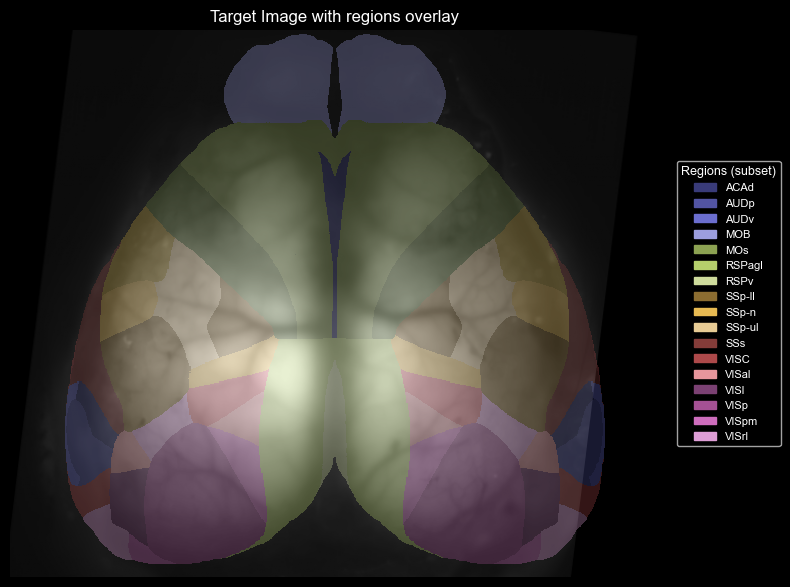

In [136]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

base = anatomical_coordinates_image.image.data[:]  # 2D target image
region = np.asarray(anatomical_coordinates_image.brain_region[:])  # strings

background = "out-of-atlas"

# Unique region names excluding background
names = np.unique(region)
names = names[names != background]
n = len(names)

# Map each region name -> 0..n-1
name_to_idx = {name: i for i, name in enumerate(names)}

# Build index image (int), background stays 0 but will be fully masked out
idx_img = np.zeros(region.shape, dtype=int)
for name, i in name_to_idx.items():
    idx_img[region == name] = i

# Mask background pixels (transparent)
idx_m = np.ma.masked_where(region == background, idx_img)

# Discrete colormap (one color per region name)
base_cmap = plt.get_cmap("tab20b", max(n, 1))
colors = base_cmap(np.arange(max(n, 1)))
cmap = ListedColormap(colors[:n] if n > 0 else colors)
cmap.set_bad(alpha=0)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(base, cmap="gray")
ax.imshow(idx_m, cmap=cmap, alpha=0.3, interpolation="nearest")
ax.set_title("Target Image with regions overlay")
ax.axis("off")

# Legend: label by brain_region
subset_names = names[::2]
handles = [
    mpatches.Patch(color=cmap(name_to_idx[name]), label=str(name))
    for name in subset_names
]

if handles:
    ax.legend(
        handles=handles,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=True,
        title="Regions (subset)",
        fontsize=8,
        title_fontsize=9,
    )

fig.tight_layout()
plt.show()

In [130]:
# IBL Bregma-centered coordinates (um) of landmarks. Coordinates are in um in the IBL frame (RAS: x=ML, y=AP, z=DV).
ibl_bregma_table = nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables["AnatomicalCoordinatesIBLBregma"]
ibl_bregma_table[:]

,x,y,z,localized_entity,brain_region
id,,,,,
0,-1950.0,-3450.0,0.0,0,OB_left
1,0.0,-3450.0,0.0,1,OB_center
2,1950.0,-3450.0,0.0,2,OB_right
3,0.0,3200.0,0.0,3,RSP_base


In [131]:
# The anatomical coordinates table references the landmarks table
ibl_bregma_table.localized_entity

localized_entity hdmf.common.table.DynamicTableRegion at 0x5030185344
    Target table: Landmarks abc.Landmarks at 0x5029847952

In [132]:
# CCF coordinates (um) of landmarks. Coordinates are in the native Allen CCF format with PIR+ orientation (x=AP, y=DV, z=ML).
allen_ccf_table = nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables["AnatomicalCoordinatesCCFv3"]
allen_ccf_table[:]

,x,y,z,localized_entity,brain_region
id,,,,,
0,8850.0,332.0,3789.0,0,OB_left
1,8850.0,332.0,5739.0,1,OB_center
2,8850.0,332.0,7689.0,2,OB_right
3,2200.0,332.0,5739.0,3,RSP_base
